# Replicating Vanderburg & Johnson 2014 using lightkurve

[Vanderburg and Johnson 2014](http://adsabs.harvard.edu/abs/2014PASP..126..948V) introduced a method for "Self Flat Fielding" by tracking how the lightcurve changes with motion of the spacecraft.  

We reproduce the publication algorithm in a [companion notebook](replicate-vanderburg-2014-k2sff.ipynb), which explains how the method works, and illustrates some of the python code underlying the code we put into `lightkurve`.

In this notebook we replicate the K2SFF method using only the `lightkurve` package.  We follow the same example K2 source, #60021426, as that in the publication.  We start from the Target Pixel File and proceed to a "systematics corrected" lightcurve plot similar to the one in the paper and in our companion notebook.  We hope to show the ease-of-use of the new `lightkurve` toolkit, and that it achieves identical performace with published papers.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from lightkurve import KeplerTargetPixelFile
from lightkurve import SFFCorrector

In [3]:
pathname = 'https://archive.stsci.edu/pub/k2/eng/long_cadence/kplr060021426-2014044044430_lpd-targ.fits'
tpf = KeplerTargetPixelFile(pathname)

We saved the mask for this target in [our previous notebook](replicate-vanderburg-2014-k2sff.ipynb), so we can just load it directly.

In [4]:
VDB_J_mask = np.load('VDB_J_2014_mask.npy')

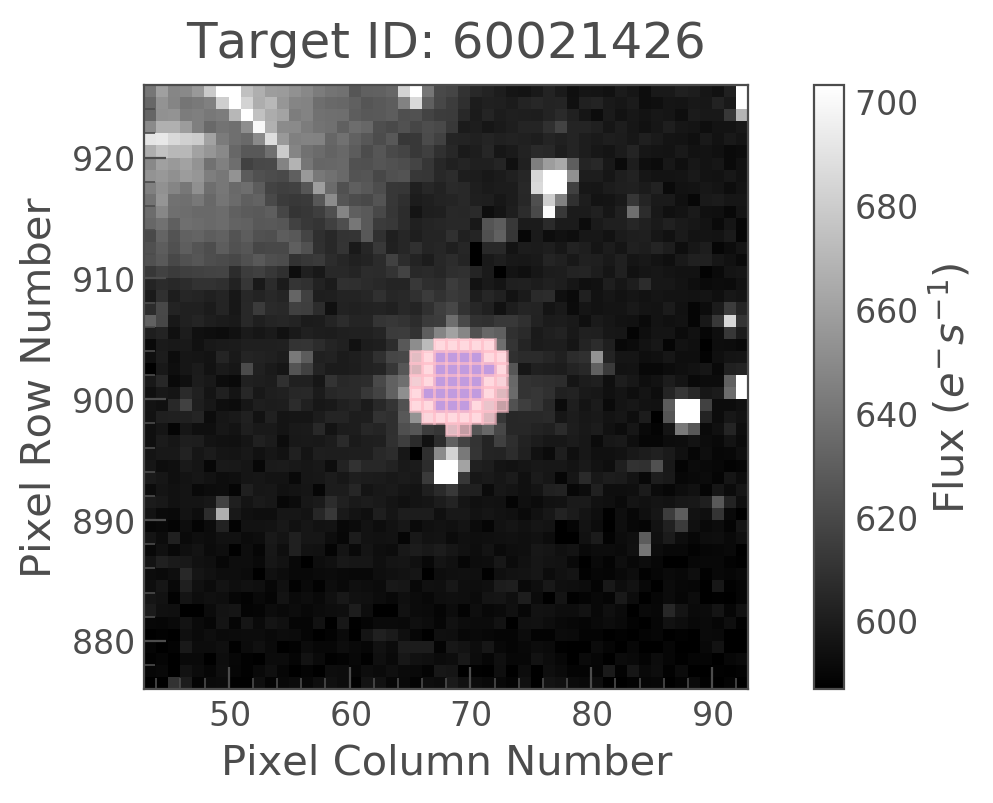

In [5]:
ax = tpf.plot(aperture_mask=tpf.pipeline_mask, mask_color='b', frame=300, 
              scale='linear', cmap='gray',show_colorbar=False)
tpf.plot(aperture_mask=VDB_J_mask, frame=300, scale='linear', cmap='gray', ax=ax, mask_color='pink');

The Vanderburg and Johnson mask is slightly bigger than the Kepler pipeline mask.

#### Data Exclusion

From the paper:
> We exclude data from the first 2.5 days of the Two-Wheel Concept Engineering Test  


> We also exclude points labeled by the Kepler pipeline as having poor quality, where the QUALITY tag of the Kepler FITS file data structure was not 0.  


> We identify the points during which Kepler's thrusters were firing through analysis of the image centroids. [...] We identify the points during which the spacecraft fires its thrusters as 5–σ outliers from the distribution of ds/dt points and exclude them from further calculations.

Thruster firings are automatically flagged in most K2 campaigns, and the exceptions are getting fixed with data reprocessing, so we will not replicate the thruster firing analysis.

In [6]:
lc_raw = tpf.to_lightcurve(aperture_mask=VDB_J_mask)

Exlude the first 2.5 days and non-zero quality flags, following Vanderburg & Johnson.

In [7]:
first_2p5_days = lc_raw.time - lc_raw.time[0] < 2.5
nonzero_quality_flags = lc_raw.quality != 0

keep_indices = ~first_2p5_days & ~nonzero_quality_flags

`lightkurve` supports indexing, slicing, and boolean masking just like `numpy`.  
Here we use boolean masking to keep the samples devoid of quality flags and poor pointing.

In [8]:
lc_trim = lc_raw[keep_indices]
lc = lc_trim.normalize()

Instantiate and apply the SFF corrector.

In [9]:
sff = SFFCorrector()

In [10]:
lc_corrected = sff.correct(lc.time, lc.flux, lc.centroid_col, lc.centroid_row, 
                           niters=1, windows=1, polyorder=5)

You can get back the long-term trend, which is useful for astrophysical variation, but less so for planet searches.  
Future `lightkurve` releases may return the trend by default.

In [15]:
long_term_trend = sff.trend[0]

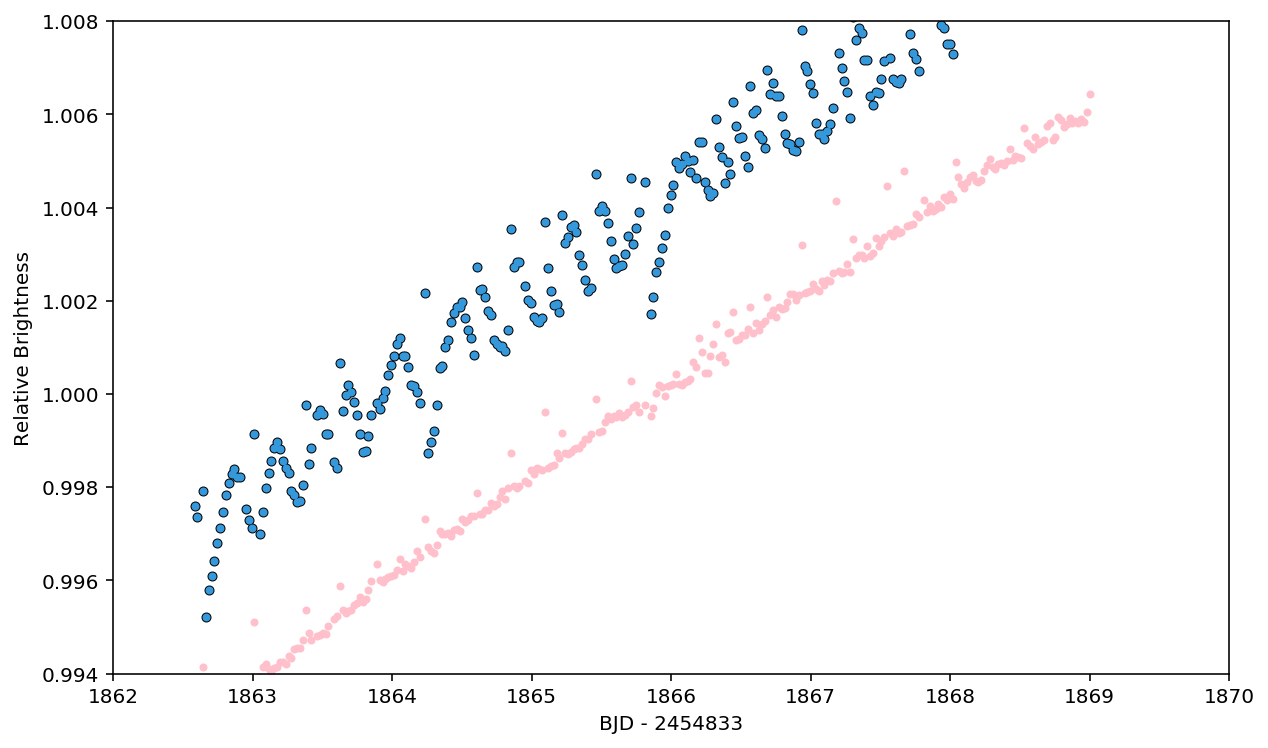

In [17]:
plt.figure(figsize=(10,6))

dy = 0.004
plt.plot(lc.time, lc.flux + dy, 'ko', ms=4)
plt.plot(lc.time, lc.flux+dy, 'o', color='#3498db', ms=3)
plt.plot(lc_corrected.time, lc_corrected.flux * long_term_trend, 'o', color='pink', ms = 3)

plt.xlabel('BJD - 2454833')
plt.ylabel('Relative Brightness')

plt.xlim(1862, 1870)
plt.ylim(0.994, 1.008);

Neat! The raw flux slope looks steeper than the publication figure, perhaps owing to different choices in aperture mask, background subtraction, or other subtle differences.  But overall the corrected flux looks very similar to the result obtained in **Figure 5**.

You can look at other diagnostics of the SFF correction with some convenience functions.

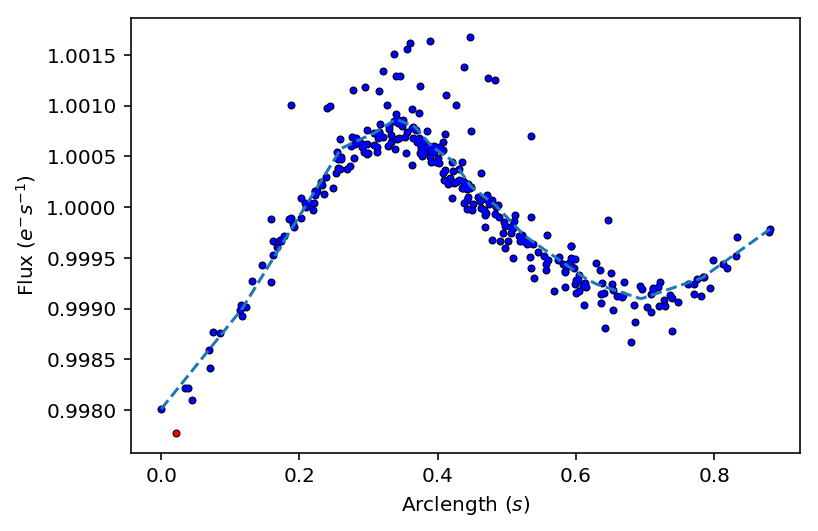

In [18]:
sff._plot_normflux_arclength();

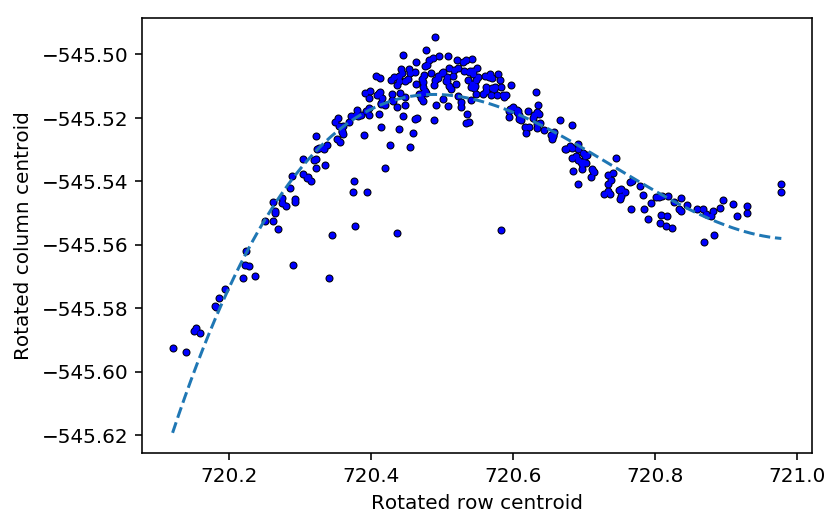

In [19]:
sff._plot_rotated_centroids()

*The end.*